# 第８週：モデルの検証と改良

今週は、機械学習の手法と、その手法にもとづく予測の精度を検証（verify）するとともに、精度を高める方法について説明する。

<span style="color: red; ">Key Points of Today's Lecture</span>


<iframe width="560" height="315" src="https://www.youtube.com/embed/Gv9_4yMHFhI" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>


<iframe width="560" height="315" src="https://www.youtube.com/embed/DVnyqnaIpoc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>



### 今日の授業の要点

- データを説明するためにモデルを立てる
- ただし、モデルが現実にデータが生成される仕組みを表現しきれているわけではない
- できるだけ良いモデルを試行錯誤したい
  -  特徴量（説明変数）を増やしたり、減らしたり（変数選択）
  - 特徴量の大きさを調整したり（標準化）
  - 係数（パラメータ）の大きさを調整したり（Lasso回帰）
- それぞれのモデルを評価する指標を求める
  - 分析手法ごとに適切な指標がある：決定係数（1に近いほどよい）、MSE（小さいほどよい）、その他（AIC、AUC、ジニ係数など）
  - カテゴリ（例えば二値、陽性と陰性など）では混合行列で判断を行うことがある
- データを分割して、過学習を防ぐ


## モデルの正しさ

第７週で機械学習の考え方の例として回帰分析を学んだ。回帰分析では、応答変数と説明変数の関係に、$y = a_1 \, x_1 + a_2 \, x_2 + \dots + a_n \, x_n + \epsilon$ のような**モデル**を当てはめて考える。ここでモデルというのは、$y$ の値が、変数 $x$ の線型結合(linear combination)によって生成される（すくなくとも近似される）ということであった。

![](https://infoart.ait231.tokushima-u.ac.jp/tuesday/docs/images/ols.png)

この図の場合、赤い直線だと、観測点と回帰直線の残差がもっとも小さくなる。

以下のサイトで、たとえば身長と靴のサイズの散布図から、最適な回帰直線を選ぶシミュレーションができるので、試してみてほしい。

https://phet.colorado.edu/sims/html/least-squares-regression/latest/least-squares-regression_en.html






実際には、線型結合では $y$ の値を正確には生成できない。そこで誤差(error)を考える。 誤差 $ϵ$ の分布に何を仮定するか（正規分布かポアソン分布か、あるいはそれ以外が妥当か）もモデル設計の一部である。

ただし、より正確にいうと、機械学習におけるモデルとは $y = a_1 \, x_1 + a_2 \, x_2 + \dots + a_n \, x_n + \epsilon$ のパラメータ $a_1, a_2, a_3$ が具体的に推定された式を意味する。パラメータが推定されたモデルにもとづいて、予測を行うのである。

このパラメータを推定する方法は1つではない。機械学習にはさまざまな技術があり、それぞれが異なるアルゴリズム（問題解決の方法）で、異なるパラメータを推定する。その意味で、複数の学習モデルが存在する。ただし、一般にモデルには正解がない。そこで、機械学習では複数のモデルを当てはめてみて、その中でもっとも効果が高いモデルを選ぶことが行われる。機械学習においては、正しいモデルを見つけるのではなく、より好ましく、より有用なモデルを選ぶことが重要になる。

なお機械学習はデータからモデルを学習するが、与えられたデータに特化してしまうという欠点がつきまとう(overfitting)。たとえば、ある会社で新入社員が出世するかどうか（キャリア）を予測することを機械学習で行ったとする。すると性別Genderが重要で、具体的には「女性」であることが、この会社で出世するのに必要な属性だと判定された。ところが、これは単に、この会社でもともと新入社員に占める女性が非常に高かったため、そのまま会社の幹部になるのも女性が多かっただけということもありうる。この場合、この機械学習モデルを、別の会社の新入社員に適用して、その会社の新入社員が出世するかどうかを予測しても、正解は出せないだろう。

このように、学習データに特化してしまう減少を**過学習**（かがくしゅう：overfitting）という。機械学習においては、過学習を避ける方法も重要である。

<span style="color: red; ">Key Points of Today's Lecture</span>

<iframe width="560" height="315" src="https://www.youtube.com/embed/dBLZg-RqoLg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>


### 変数選択

回帰分析は、応答変数と説明変数の関係をモデル化する手法であった。したがって、説明変数の選択が重要になる。たとえば、ある日のある地域のビール消費量(consumption)を予測するのに、その日の気温や湿度(humidity)、天候はそれぞれ重要だろうが、では大気中の二酸化炭素濃度(carbon dioxide concentration)は影響しているだろうか。

データから予測を行うには、そのデータについての知識（専門知識、ドメイン知識）が重要であることはいうまでもない。当然、応答変数に影響のありそうな説明変数を選ぶわけだが、その強さについて事前の知識(prior knowledge)がない、あるいは不明な場合、とりあえず、手もとにある変数をすべて分析につかうことになるだろう。

この場合、どの変数がどれだけ予測に役に立っているかを確認する必要がある。前回、説明変数の有効性（役にたつか、たたないか）を**検定**する方法を説明した。手順としては、推定された係数のp値を確認し、これが0.05未満であれば役に立つ変数であると判断するが、p値が0.05を超える変数については役に立たない説明変数とみなす。役に立たないと判断された変数は、説明変数からとりのぞき、再び分析を実行して、残りの変数について有意かどうかを判断する。この作業を繰り返して、説明に役立つ変数だけを残すのである。これを**変数選択**（へんすうせんたく：variable selection）という。

説明変数の数が多い場合、回帰分析と検定による判断を何度も繰り返す必要があるので手間（面倒）であるが、しかし、多くのソフトウェアには、この作業を自動化する機能がある。この場合、AICという基準(criterion)で説明変数の選択が行われる。

### AIC



回帰分析における変数選択では、実際には説明変数について推定された係数のp値ではなく、**AIC**という指標で判断が行われる。一般に実務で重要視されるのは、説明変数の有効性よりも、回帰モデルにどれだけ予測の精度があるかである。予測の精度を確認する指標として、前の週では**決定係数**（coefficient of determination）を紹介した。決定係数は 0 から 1.0 の範囲の実数で、1.0 に近いほど、予測値と実測値の差（残差, residuals）が小さいことを意味する指標であった。

ただし、決定係数には欠点がある。それは説明変数の数をふやすと、それぞれが応答変数に影響していようがいまいが、決定係数は単純に大きくなる。 たとえば、日本で１日に消費されるビールの量を説明するのに、アメリカ大統領が１日に歩く歩数(number of steps)を説明変数として追加すると（きわめてわずかではあろうが）、決定係数は大きくなるのである。

一般に、統計モデルにおいては、予測の精度が犠牲にならない限り、説明変数の数は少ないほうがよいという考え方がある（オッカムの剃刀、Occam's razor）。

[外部サイト：ウィキペディア：オッカムの剃刀](https://ja.wikipedia.org/wiki/%E3%82%AA%E3%83%83%E3%82%AB%E3%83%A0%E3%81%AE%E5%89%83%E5%88%80)

そこで、説明変数の数を増やすことを罰(penalty)として、残差の大きさを表す指標に加える方法が提案されている。これは赤池情報量規準(あかいけじょうほうりょうきじゅん, Akaike information criterion, AIC)と呼ばれ、国際的に広く利用されている（赤池とは、日本の統計数理研究所の所長をつとめた統計学者である）。

[外部サイト：ウィキペディア：赤池弘次](https://ja.wikipedia.org/wiki/%E8%B5%A4%E6%B1%A0%E5%BC%98%E6%AC%A1)

$$
AIC = -2 ln L + 2 k
$$

ここで $ln$ は自然対数を、また $L$ は最大尤度（尤度、ゆうど Likelihood については前回説明した）、そして k は推定されるパラメータの数である（式を覚える必要はない）。重回帰では、モデルのパラメータは説明変数ごとに推定されるので、結局、上の式は説明変数が増えるほどAICは大きくなることを意味している。

AICは、小さいほど、モデルとしての当てはめが良いと判断される。ただし、AICは相対的なものなので、ある値より小さければ良いという規準ではない。また、別のデータの分析結果と比較できるものでもない。

AIC規準を使うことで、重回帰において複数の説明変数があるなかで、どのような組み合わせが有効かを判断することができる。統計ソフトウェアのほとんどは、自動的に変数の組み合わせを作成し、それぞれごとにAICを求め、その規準値がもっとも小さいという意味で最良のモデルを提案してくれる。もっとも、機械まかせにすると、現実には重要な変数も削除されてしまうことも多いので、注意が必要である。

一方、機械学習では、応答変数にあまり関係のない説明変数を扱うのに、別の方法が取られることが多い。重回帰でいえば、予測に役に立たない説明変数の係数を 0 にしてしまうか、あるいは小さく推定するということが行われる。これを正則化 （せいそくか：regularization）という。

## 正則化回帰モデル

<span style="color: red; ">Key Points of Today's Lecture</span>

<iframe width="560" height="315" src="https://www.youtube.com/embed/NGf0voTMlcs" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

回帰分析では、応答変数と予測変数の差を最小にするよう説明変数の係数が推定される。この係数をパラメータとよんだ。

パラメータは、インプットとなるデータにもとづいて学習されるが、一般に、学習に利用されたデータについて、その応答変数を予測すると、比較的高い予測精度が得られることになる。

しかし、別に新しく（学習に使った変数と同じ変数が記録されている）データが得られたときに、この学習モデルを使って予測を行うと精度が低くなることが多い。 これは入力したデータ数がたりないか（学習不足、がくしゅうぶそく）、あるいは**過学習**と呼ばれる現象である。 後者は、たまたま得られたデータセットにだけある誤算を、モデルの方は予測に役立つ数値であると判断してしまうからである。 この学習結果は、特定のデータセットにのみ適応しているため、別のデータセットを入力しても、十分な予測精度が出せないのである。

<!--
学習の偏りについて、機械学習では、バイアスとバリアンスという概念がある。
バイアスとはモデルが学習不足の状態を指し、予測の期待値と真の値との差（の自乗）で評価される。
バリアンスとはモデルがインプットされたデータに過剰に適合している状態を指し、予測のばらつき（つまり分散）で評価される。
直感的に説明すると、モデルの予測値と実際の値との差は、バイアスとバリアンスに分解される（正確には、さらに誤差が加わる）。
要するに、バイアスとバリアンスを小さくすれば、モデルの当てはまりは改善される。

一方、機械学習の手法においては、モデルの構成に関わるパラメータ（これをハイパーパラメータという）があり、これらの調整に予測の精度は左右される。
予測や分類を学習するための手法と、推定されるべきパラメータの組み合わせには多数の候補がある。
また、選択した手法によって予測ないし分類の精度は異なるため、比較検証も必要となる。

-->

回帰モデルでは、過学習を避ける方法として、**正則化回帰モデル**（せいそくかかいきもでる：regularized regression model）が提案されている。

モデルの汎化性能(generalization performance)を高め、未知のデータに対しても予測精度をあげるためには、推定されるべきパラメータが、特定の学習データにだけある特徴に適合しないことが重要なのである。

回帰分析の場合、パラメータは説明変数の係数だが、これを最適化する方法として、パラメータが過大に見積もられること(over estimate)を防ぐペナルティーを加える方法がある。 回帰分析では、予測値と実測値のずれをもとにパラメータを推定するが、この際、特別に項(term)を追加するのである。

$$
min \left [ \frac{1}{2N} \sum_{i=1}^N (y_i - \beta_0 - x_i^T \beta) + \lambda P_\alpha (\beta) \right] \\
P_\alpha (\beta) = \sum_{j=1}^p \left[ \frac{1}{2} (1 - \alpha) \beta_j^2 + \alpha|\beta_j| \right]
$$

覚える必要はないが、上の２行目が罰則（ばっそく：penalty）にあたる。この式でパラメータは $\beta$ で表現されているが、それらの総数とそれぞれの数値が大きくなると、この最後の項も大きくなり、したがって式全体で計算される数値も大きくなることがわかるだろうか（なお、$\lambda$はハイパーパラメータだが、あとで説明する）。
ペナルティをこのように調整した回帰分析として、広く使われているのが以下に説明する3つの方法である。

### その１：Lasso 回帰


Lasso 回帰は上の式で $\alpha$ を 1 とした場合にあたり、係数の絶対値（ぜったいち：absolute value）の和をペナルティとした推定方法である。これを **L1ノルム**（正則化、せいそくか）と呼ぶ。
また $\lambda$ は正則化パラメータと呼ばれ、大きいほどペナルティ（罰則）の影響が強くなり、この結果、変数に推定される係数（パラメータ）のうちいくつかは完全に 0 になる。すなわち、有効な説明変数の数が少なくなる。$\lambda$ の具体的な値は分析者が指定する必要がある。極端にいうと、このパラメータは、データそのものとは直接関係ない。このように分析手法の固有（こゆう）で分析者の判断で指定するパラメータを**ハイパーパラメータ**という。一般に、適切なハイパーパラメータの値がわかっていることはない。そこで、どうするかというと、機械学習では、ハイパーパラメータの候補を片っ端から適用してみて、その中で、予測にもっとも役立ったハイパーパラメータを選択する、という方法が使われる（これをグリッドサーチとよぶ）。

### その２：Ridge 回帰


一方、Ridge 回帰
は上の式で $\alpha$ を 0 とした場合で、係数の 2 乗和をペナルティとした推定方法である。これを **L2ノルム** と呼ぶ。
Ridge 回帰では説明変数の回帰係数を 0 の方向に縮小（しゅくしょう：shrink）するが、Lasso回帰とは異なり、完全に 0 になることはない。


### その３：Elastic Net 回帰

Elastic Net 回帰では、回帰係数の 2 乗和と絶対値の和を両方を取り込み、ハイパーパラメータ $\alpha$ によって、その割合を調整する。


## 回帰モデルの当てはめ

実際にデータを使って正則化回帰モデルを当てはめてみよう。
先週紹介した`Boston Housing`データを使う。なお、ここでは **sklearn** ライブラリを利用する。

In [3]:
from sklearn.datasets import fetch_openml
boston = fetch_openml(name='boston')
print(boston.DESCR)

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

/home/ishida/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/datasets/_openml.py:301: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1.
  warn(
/home/ishida/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


また、DESCR 属性を表示させると Boston データの概要を確認できる。

**sklearn** の付属データは説明変数と応答変数があらかじめわけてある。
説明変数は `boston.data` 、応答変数は `boston.target` としてアクセスできる。

### 過学習

過学習を避ける方法として、機械学習の分野で広く使われているアイデアの１つは、きわめてシンプルである。 まず、てもとのデータを２つに分割するのである。そして、一方を**訓練データ**(training data)セット、他方を**テストデータ**(testing data)セットとする。（データサイズに余裕があれば、訓練データで作成したモデルを検証データ (validation data) で確認し、これらの結果を受けてテストデータで予測の精度をみるという手順も広く行われている）。

そして、訓練データで分析を行い、その結果を使ってテストデータを予測して、精度を確かめるのである。 シンプルだが、モデルの汎化性能(generalization performance)を上げることができる手法である。 この方法を**ホールドアウト**(hold out)という。

## クロスバリデーション

より効果的なのは、ホールドアウトを繰り返すことである。これを**クロスバリデーション**(cross validation)、**交差検証法**（こうさけんしょうほう）という。たとえば、最初にすべてのデータを10個に分割し、そのうち9個を訓練データセットとして学習する。次に学習されたモデルを使って、残った1個のデータセットを予測して、その精度を調べる。続けて、いま訓練データとして使った9個のデータセットのうち1つをテストデータにする。残りの8個のデータセットと、１回めにテストデータとして使ったセットを合わせた合計9個のデータセットを使って、再びモデルを訓練して精度を求める。これを10回繰り返す。 モデルの精度は、これら10個の精度の平均で評価する。これは **K分割交差検証法**（Kぶんかつこうさけんしょうほう：K-fold cross-validation）という。Kには10が使われることが多い。

ホールドアウト法を試してみよう。
**sklearn** にはデータを分割する機能があるので、それを利用する。

In [22]:
from sklearn.model_selection import train_test_split
# 訓練データとテストデータを8:2で分割
train_x,test_x,train_y,test_y = train_test_split(boston.data, boston.target,train_size=0.8,random_state = 1)

この命令を実行すると、説明変数からランダムに抽出された80％のデータが`train_x` となる。のこり20％がテストデータ用の説明変数`test_x` である。
また説明変数から抽出された80％のデータに対応する応答変数 `target` が`train_y`として、残り20％が `test_y` 、つまりテストデータの応答変数として使われる
（テストデータの応答変数は、`test_y` は、訓練モデルにもとづいてテスト用説明変数を予測した結果と照合するための正解ラベルとして使われる）。

### データの標準化

さて、次にデータの**標準化**(standardization)あるいは**正規化**(normalization) を行う。これは、変数のスケールが分析に及ぼす影響をならす（影響が同じようになる）ための処理である。

たとえば、人間の健康をしらべるために、身長と体重を説明変数として使うことを考えよう。ここで体重がグラム（体重は50000グラムとか80000グラムとかいう単位）、身長がメートル（1.6メートルとか1.8メートルとか）で記録されていた場合、前者に比べて後者のスケールがずっと小さいので、後者の説明変数としての重要度が小さくなってしまう恐れがある。

そこで、機械学習では**標準化**あるいは**正規化**という方法で説明変数のスケールを統一することが行われる。 標準化は以下の式を使って、データの平均値と標準偏差の結果を使って行う。これにより、変数の平均値は0、標準偏差は1に変換される。

$$
x_{std} = \frac{x - \mu}{\sigma}
$$

一方、正規化はデータを 0 から 1の間に収める方法である。そのためには、個々のデータから最小値を引いた値を、最大値と最小値の差で割れば良い。

$$
x_{norm} = \frac{x - min(x)}{max(x) - min(x)}
$$


ただし、正規化では外れ値の影響が強くなるため、一般的には標準化が利用されることが多い。標準化についても、**sklearn** の機能を使うことができる。


In [23]:
from sklearn.preprocessing import StandardScaler
stds = StandardScaler()
train_x_std = stds.fit_transform(train_x)
test_x_std = stds.transform(test_x)

標準化の結果を確認しよう。各変数の平均値と標準偏差を求めてみると ０（正確には０に極めて近い値、これはコンピュータ内部の計算の仕組みによる誤差である）および１になっているのが確認できるだろう。




In [24]:
import numpy as np
print(np.apply_along_axis(np.mean, 0, train_x_std ))
print(np.apply_along_axis(np.std, 0, train_x_std ))

[ 2.63815372e-17 -2.19846143e-18  2.02258452e-16  1.09923072e-18
  2.24243066e-16 -2.32597220e-15 -1.53892300e-16 -1.95663068e-16
 -8.79384574e-17  1.36304609e-16  3.29769215e-16 -7.21095351e-16
 -3.42959984e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


テストデータの説明変数も標準化を行うが、注意するのは、標準化の計算に使う平均値と標準偏差は、*訓練データから求めた数値を使うこと*である。テストデータから平均値と標準偏差を計算すると、その値は、訓練データの平均値および標準偏差を異なるはずである。

上のコードの`stds.fit_transform(train_x)`は訓練データにもとづいて標準化の計算(fit)をして変換(transform)しているが、続く`stds.transform(test_x)`は訓練データに使った標準化の計算式をテストデータにあてはめて変換している（`stds`に計算結果が保存されているのである）。

準備が整ったので、**sklearn** で通常の回帰分析を実行してみよう。

In [25]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X=train_x_std, y=train_y)

LinearRegression()

モデルを当てはめた結果が、ここでは `lr`  に保存されている。

各説明変数の係数は**sklearn**では以下のようにして `coef_` を使って確認できる。

In [26]:
lr.coef_

array([-1.02670073,  1.35041325,  0.12557673,  0.57522815, -2.28609206,
        2.13083882,  0.12702443, -3.17856741,  2.64730569, -1.87781254,
       -2.14296387,  0.6693739 , -3.92551025])

さて、ここでは回帰分析の結果について、係数のp値を使って判断することは行わない。そもそも、**sklearn**では係数のp値は求められていない（手作業で計算することはできるが、p値が必要であれば**statsmodels**を使ったほうが簡単である）。

機械学習では、予測精度は**平均二乗誤差** (へいきんじじょうごさ：MSE, Mean Squared Error) や、二乗平均平方根誤差 (じじょうへいきんへいほうこんごさ：RMSE, Root Mean Squared Error) などで判断が行われる。


$$
\text{MSE} = \frac{1}{n}{ \sum_{i=1}^{n} (y_i - \hat{y})^2}
$$

$$
\text{RMSE} = \sqrt{ \frac{1}{n}{ \sum_{i=1}^{n} (y_i - \hat{y})^2} }
$$

いま学習されたモデルを使って、学習用の説明変数から応答変数を予測してみよう。ただし、学習用の説明データから、同じく学習用の応答変数を予測してみると、一般に精度は高い。ここでは、確認として推定してみるだけである。

実際には学習されたモデルの性能は、テストデータに対する予測精度で評価する。

予測値と、実際の応答変数の値を比較し、MSEで差の大きさを調べてみよう。

MSEを求めるは 、**sklearn**の`mean_squared_error`を適用する。

In [27]:
y_train_predict = lr.predict(train_x_std)
from sklearn.metrics import mean_squared_error
mean_squared_error(train_y, y_train_predict)

21.862794714879602

MSEは21.86と求められた。次に、学習モデルを**テストデータ**に適用して、予測値を求めてみよう。 最初に、テスト用説明変数を標準化する（繰り返しになるが、標準化で使われる平均値と標準偏差は、訓練用データから計算された数値である）。

In [9]:
test_x_std = stds.transform(test_x)
y_pred = lr.predict(test_x_std)

MSEを求めよう。

In [10]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, y_pred)

23.380836480270208

約23.38と求められた。MSEは誤差の合計値から求められた数値なので、小さいほうがよい。訓練データを予測した結果と比べると悪くなっているが、テスト用データはモデルにとっては未知のデータであるため、訓練データよりも予測の結果は悪くなるのが普通である。

次にLasso回帰を実行してみよう。引数 `alpha` は正則化の大きさを指定する**ハイパーパラメータ**で、上の正則化で示した式の $\lambda$ に相当する（ややっこしいが、 $\alpha$ ではない）。

In [11]:
from sklearn.linear_model import Lasso
llr  = Lasso(alpha=0.2)
llr.fit(X=train_x_std, y=train_y)
llr.coef_

array([-0.43653278,  0.52991519, -0.        ,  0.49446359, -1.20953885,
        2.42988267, -0.        , -1.72236319,  0.0827378 , -0.        ,
       -1.86732651,  0.46416112, -3.84221519])

実行すると、各説明変数のパラメータの推定値が表示されるが、ここで、いくつかの変数の係数が0になっていることに注意して欲しい。つまり、それらの説明変数はモデルから取り除かれたのと同じ効果になっている。説明変数のうち、どれくらいの数について係数を0にしてしまうかを決めているのが、ハイパーパラメータのである。（たとえば `alpha=0.2`の数値を変えて実行してみよう。）

Lassoによる学習モデルを使って、まず訓練用データから予測を行いMSEを求めてみよう。

ここまでの講義動画はCアカウントでログインしていれば以下で視聴できます。

## ＊ここまでの要約ビデオ１ （過去の講義の録画です）

<font color="red">石田講義録画</font>
<iframe width="640" height="360" src="https://web.microsoftstream.com/embed/video/03856339-67ee-4c3f-97d3-a616c1ee50f1?autoplay=false&showinfo=true" allowfullscreen style="border:none;"></iframe>

In [12]:
y_lasso_train_predict = llr.predict(train_x_std)
mean_squared_error(train_y, y_lasso_train_predict)

23.387373945391804

23.38となっている。次に、Lassoモデルを使ってテストデータを予測してMSEを確認する。

In [13]:
y_pred = llr.predict(test_x_std)
mean_squared_error(test_y, y_pred)

25.805048502327722

結果は約 25.8 となった。 このデータにLassoを適用したところ、通常の回帰分析より当てはめ結果は悪くなってしまった。このデータの場合、一部の説明変数の係数を0にしてしまう処理は適切ではないのかもしれない。 そこでRidge回帰を実行してみよう。Ridge回帰は、説明変数の係数を完全に0とはせず、小さくする（縮約、shrink）させる方法である。

In [14]:
from sklearn.linear_model import Ridge
rlr  = Ridge(alpha=0.5)
rlr.fit(X=train_x_std, y=train_y)
rlr.coef_

array([-1.02108688,  1.33711724,  0.11027979,  0.57729757, -2.266897  ,
        2.13812126,  0.12163688, -3.15827767,  2.59839137, -1.83218852,
       -2.1380779 ,  0.66927046, -3.91526704])

係数を確認すると、いずれも0にはなっておらず、かつ、通常の回帰分析の結果と比べると、いずれの係数も、やや小さな値になっている。 予測を実行してMSEを確認する。まず訓練データである。

In [15]:
y_train_pred_ridge = rlr.predict(train_x_std)
mean_squared_error(train_y, y_train_pred_ridge)

23.380811973425136

次にテストデータのMSEである。

In [16]:
y_test_pred_ridge = rlr.predict(test_x_std)
mean_squared_error(test_y, y_test_pred_ridge)

23.380811973425136

約23.38となり、Ridge回帰では訓練データとテストデータそれぞれのMSEの差が比較的小さく、かつ通常の回帰でテストデータを予測した場合のMSEと同じ（正確にはより小さい）値が得られている。過学習が避けられていると評価することができるだろう。

結果としてRidge回帰による当てはめがすぐれていると判断できる。

### クロスバリデーションの実際

<span style="color: red; ">Key Points of Today's Lecture</span>
<iframe width="560" height="315" src="https://www.youtube.com/embed/fSytzGwwBVw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

## ＊ここからの要約ビデオ２ （過去の講義の録画です）
<font color="red">石田講義録画</font>
<iframe width="640" height="360" src="https://web.microsoftstream.com/embed/video/823830c2-433e-4f80-b55e-a72a56b27b6f?autoplay=false&showinfo=true" allowfullscreen style="border:none;"></iframe>

Lasso回帰とK分割交差検証法を併用してみよう。

詳細は省くが、`LassoCV(alphas=10 ** np.arange(-6, 1, 0.1), cv=10)` では、データを分割する個数 K に 10を指定し（デフォルトである）、ハイパーパラメータ `alpha` を指定の数値の範囲で探索している（`10 ** np.arange(-6, 1, 0.1)` の部分だけをPythonで実行してみると、どのような数値がどれだけ生成されるのかが分かるだろう）。


In [17]:
import numpy as np
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas=10 ** np.arange(-6, 1, 0.1), cv=10)
lasso_cv.fit(X=train_x_std, y=train_y)

LassoCV(alphas=array([1.00000000e-06, 1.25892541e-06, 1.58489319e-06, 1.99526231e-06,
       2.51188643e-06, 3.16227766e-06, 3.98107171e-06, 5.01187234e-06,
       6.30957344e-06, 7.94328235e-06, 1.00000000e-05, 1.25892541e-05,
       1.58489319e-05, 1.99526231e-05, 2.51188643e-05, 3.16227766e-05,
       3.98107171e-05, 5.01187234e-05, 6.30957344e-05, 7.94328235e-05,
       1.00000000e-04, 1.25892541e-0...
       2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
       6.30957344e-02, 7.94328235e-02, 1.00000000e-01, 1.25892541e-01,
       1.58489319e-01, 1.99526231e-01, 2.51188643e-01, 3.16227766e-01,
       3.98107171e-01, 5.01187234e-01, 6.30957344e-01, 7.94328235e-01,
       1.00000000e+00, 1.25892541e+00, 1.58489319e+00, 1.99526231e+00,
       2.51188643e+00, 3.16227766e+00, 3.98107171e+00, 5.01187234e+00,
       6.30957344e+00, 7.94328235e+00]),
        cv=10)

Pythonにおいて、データに分析手法を当てはめる（つまりデータを学習する）手順は、だいたい共通している。

1. `import`で手法にアクセスできるようにする
2. 手法にオプション指定して呼び出す（上のコードでは `LassoCV()`）
3. データに`fit()`を適用して学習を行う

そして、学習されたモデルを使って予測を行い、その精度を残差平方和（の平均）で確認する。


In [18]:
y_pred_cv = lasso_cv.predict(test_x_std)
mean_squared_error(test_y, y_pred_cv)

23.522336780372967

MSEは約23.52と改善されている。


## ロジスティック回帰とLasso

ロジスティック回帰にも正則化を適用することができる。簡単に紹介しよう。

ここで各種手法を紹介するデータとして`iris`「あやめデータ」を使う。

[外部サイト：Wikipedia：iris](https://en.wikipedia.org/wiki/Iris_(plant))

`iris` データはアヤメの品種(species)、Setosa, Versicolor, Virginica の3品種、それぞれ50個体、合計150個体について、Sepal Length（がく片の長さ）、 Sepal Width（がく片の幅）、 Petal Length（花びらの長さ）、 Petal Width（花びらの幅）の4つの変数、つまりは特徴量(features)が記録されている。


![](images/IrisDataPic_SepalsPetals_LengthWidth.png)

機械学習では、これら４つの特徴量から、観測された個体の品種を予測するモデルの例としてよく取り上げられる。Pythonでは以下のようにして `iris` データを読み込むことができる。また、`DESCR` 属性を表示させると `iris` データの概要を確認できる。

In [19]:
from sklearn import datasets
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

散布図行列を作成して、４つの特徴量から品種を分類できそうか確認してみよう。`sklearn`のデータ形式だと **seanborn** パッケージでグラフを作成するのに不便なので、ここではデータフレームに変換して可視化(visualize)する。

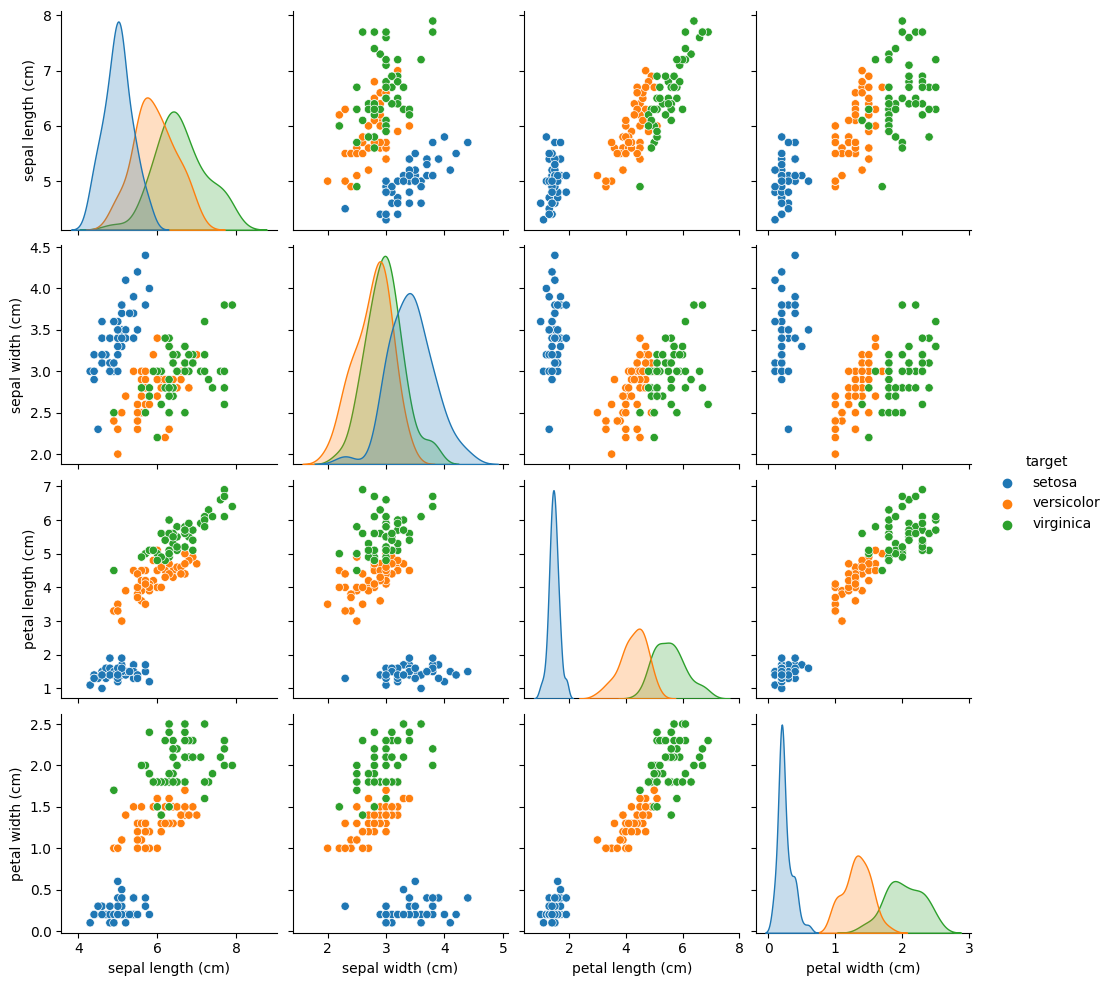

In [20]:
import pandas as pd
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target_names[iris.target]
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df, hue='target')

図の、例えば右上（左下）は、Sepal Length と Petal Width の散布図である。ここからは、青い点で表された virginica 種と、残り２種がはっきりと分けられている。 その他の散布図でも、青い点で表された virginica 種と、残り２種はうまく分けられているようである。

しかしながら、versicolorとvirginicaは、どの散布図においても、完全には分けられていない。 散布図からは、versicolorとvirginicaを完全に分けるのは難しいようであるが、これをモデルとして考え、予測してみよう。

In [21]:
df2 = df[(df['target']=='versicolor') | (df['target']=='virginica')] 
df2.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
50                7.0               3.2                4.7               1.4   
51                6.4               3.2                4.5               1.5   
52                6.9               3.1                4.9               1.5   
53                5.5               2.3                4.0               1.3   
54                6.5               2.8                4.6               1.5   

        target  
50  versicolor  
51  versicolor  
52  versicolor  
53  versicolor  
54  versicolor

`iris` データフレームから説明変数（特徴量）と応答変数（品種）を取り出し、さらに、それぞれを訓練用とテスト用に分割する。 なお、４つの特徴量はいずれも単位が同じであり、かつ大きさに極端な差もないため、ここでは標準化は省略する。

In [22]:
# 説明変数を用意（target列を落とす）
X = df2.drop('target', axis=1)
# versicolorをクラス0, virginicaをクラス1とする
y = df2['target'].map({'versicolor': 0, 'virginica': 1})
# データを分割# 80%のデータを学習データに、20%をテストデータにする
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

ロジスティック回帰をLasso回帰として実行してみよう。`LogisticRegression()` の引数 `penalty` に `l1`　（えるいち）を指定すれば Lasso 回帰、 `l2` （えるに）を指定すれば Ridge回帰が実行される。ここで引数 `solver` については、深く考えないでよい。

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1',
    solver='liblinear', C=1.1)
model.fit(X_train, y_train)

LogisticRegression(C=1.1, penalty='l1', solver='liblinear')

ここでLogistic回帰の内部では個体が virginica である確率を計算している。一般にはこの確率が0.5を超える場合は 1 'virginica'と判定し、さもなければ 0 'versicolor'と判定される。

テストデータから予測を行ってみる。

In [24]:
y_pred = model.predict(X_test)
y_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0])

ところで、ロジスティック回帰は、応答変数が２値のうち、どちらになるのか、そのラベルを予測する（つまり分類する）モデルである。 先に説明した MSE は、回帰問題のように応答変数が数値の場合に適切な指標である。 この場合、予測の精度はどのように求めたらよいであろうか。 分類をおこなうという問題において、予測の精度を確認する方法としては、たとえば、全体のうち正しく分類できた割合を求めればいいであろう。 たとえば、テストデータに20個体あり、学習モデルでそのうち18個については正しく予測できたのあれば、正解の割合は 18/20=0.9 である。

機械学習で2値を分類する課題では、正解の割合を確認する表として**混同行列**（confusion matrix）を作成することが多い。

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred.round())
labels = ['versicolor', 'virginica']
cm = pd.DataFrame(cm, columns=labels, index=labels)
cm

versicolor  virginica
versicolor           8          2
virginica            0         10

## ＊ ここからの講義動画３

（過去の講義の録画です）

<font color="red">石田講義録画</font>
<iframe width="640" height="360" src="https://web.microsoftstream.com/embed/video/de9d9eba-4d91-43d7-96a8-07f184026ee2?autoplay=false&showinfo=true" allowfullscreen style="border:none;"></iframe>

出力はわかりにくいが、以下のように書き直せる

<center>

|                      | 予測が versicolor(0)   | 予測が virginica(1) |
|----------------------|------------------------|---------------------|
| 実際が versicolor(0) | 8     (True Positive) | 2  (False Positive) |
| 実際が virginica(1)  | 0     (False Negative) | 10 (True Negative)  |
</center>

行に実際の（本当の）ラベルが、列に予測されたラベルが配置されており、該当の個数が記録されている。 セルに追記されているNegativeやPositiveは、それぞれ 0 と 1 に対応する。この分析の場合であれば 0 が versicolorで 1 が virginicaである。True Negativeというのは、予測で 0 とされた個体が実際に 0 であること、False Positive は予想で 1 とされた個体が実際には 0 であったことを意味している。True NegativeとTrue Positiveのあるのが予測が正しくあたった個数である。 つまり、Lasso回帰が正しく予測したのは、20個体中 18 個となる。ちなみに、この割合を**正解度**(accuracy)などといい、分類で予測の精度をはかるために使われる基準の１つである。

<center>

|                      | 予測が陽性  | 予測が陰性 |
|----------------------|------------------------|---------------------|
| 実際が陽性 | 　真陽性  | 偽陰性 |
| 実際が陰性 |   偽陽性 | 真陰性  |
</center>


例えば、病気の陽性検査の場合、それぞれの意味は以下のようになる。


- 真陽性・実際に病気だし，検査でも陽性
- 真陰性・実際に病気でないし，検査でも陰性
- 偽陽性・実際は病気でないのに，検査では陽性が出てしまう(過検出)
- 偽陰性・実際は病気なのに，検査では陰性になってしまう(検出漏れ)



他に、よく使われるのが、AUC(Area Under Curve) である。AUCは以下のグラフで、ROC (Receiver Operating Characteristic) 曲線（この例では階段のようにギザギザしているが） より右下の面積にあたる。この場合、プロット全体の面積が1.0として、曲線より右下の面積が 1.0 にちかいほど、モデルの予測精度が高いと判断される。

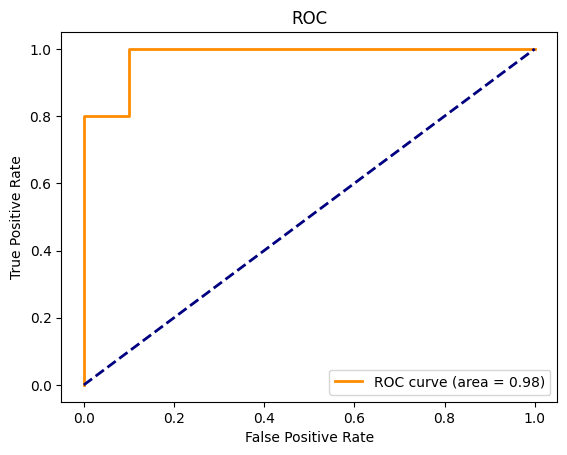

In [27]:
import matplotlib.pyplot as plt
y_score = model.predict_proba(X_test)[: ,1]
from sklearn.metrics import roc_curve, auc
fpr, tpr,thred = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

## ROCとAUC

<span style="color: red; ">Key Points of Today's Lecture</span>
<iframe width="560" height="315" src="https://www.youtube.com/embed/4jRBRDbJemM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

回帰では応答変数が数値であり、精度の評価として MSE を利用した。一方、ロジスティック回帰では応答変数が２値カテゴリであるため、MSEを評価に使うことはできない。２値分類では、モデルの予測と応答値が一致した数で評価を行う。

２値カテゴリの水準には、たとえば「支持」「不支持」、あるいは「合格」「不合格」、あるいは「成功」「失敗」など、さまざまな可能性があるが、一般には「陽性（ポジティブ）」「陰性（ネガティブ）」として表現することが多い。

２値分類では、ある観測値の水準がポジティブであるかどうかは、モデルから求めた確率を基準に判断する。単純には確率が 0.5 を超えれば、その観測値はポジティブ、さもなければネガティブと判定するのが簡単だろう。これを閾値（しきいち、いきち：threshold）という。

閾値を小さく設定すれば（たとえば 0.1）、より多くの観測値がポジティブと判定されるであろう。逆に、閾値が 0.9 であれば、ほとんどがネガティブと判定されるかも知れない。仮に閾値を 1.0 とすれば、すべてをネガティブだと判定することになる。

たとえば 10 個の個体のうち実際にネガティブなのは 3 個だとしても、閾値が 1.0 であれば、予測モデルでは 10 個すべてがネガティブだとだ判定される（下の表で 1 列目）。

<center>

|                    | 予測でネガティブ 0 | 予測でポジティブ 1 |
|-----------------|--------------------|--------------------|
| 実際にはネガティブ 0 | (TN) 3            | (FP)  0             |
| 実際にはポジティブ 1 | (FN) 7            | (TP) 0             |
</center>

ちなみに、実際にポジティブな観測値（上の例では7個）のうち、モデルで正しくポジティブと判定される割合を**感度**（かんど：sensitivity）あるいは**再現率**（さいげんりつ：recall）という。上の表で、感度は $0/(7+0)= 0$ （ポジティブ行の内訳）となる。一方、実際にはネガティブな観測値（上の例では3個）のうち、モデルが正しくネガティブと分類した割合は**特異度**（とくいど：specificity）という。上の表では $3/(0 + 3) = 1$ である（ネガティブ行の内訳）。ちなみに、実際にネガティブな観測値（上の例では3個）のうち、誤ってポジティブと分類された割合は**偽陽性率**（ぎようせいりつ：false positive rate）というが、この場合は、 $0 /(0 +3) = 0$ である。

特異度は数値の上では 1.0 となるが、このモデルではポジティブな観測値を正しく識別できていない。また、すべての件数（応答変数の数）を分母(denominator)とし、分子(numerator) には、ポジティブ を正しくポジティブと分類できた件数とネガティブを正しくネガティブと分類できた件数の合計をおいた割合を**正解度**(Accurary)などという。この場合だと、$\frac{0+3}{0 + 0 + 7 + 3}$ ということになる。

誤ってポジティブと判定される割合は下げたいが、 同時に、実際にポジティブである観測値は正しくポジティブと判断できるようなモデルを採用したいわけである。そこで、閾値を変えていった場合の特異度と感度の変化を確認するために ROC (Receiver Operating Characteristic) 曲線を作成する。

ROC (Receiver Operating Characteristic) 曲線は、横軸に偽陽性率（1-特異度）を、また縦軸に感度（真陽性率）を取ったグラフである。

たとえば、偽陽性率が0となるような閾値（分析データによるため、必ずしも0.0ではない）を使った場合（上のROC曲線の左端、原点）の時、このデータの陽性データのうち、8割が正しく陽性と分類される（縦軸の 0.8)。逆に、すべての陰性データを陽性として判断してしまうような閾値（分析データによるため、必ずしも1.0ではない）の時、陽性のデータはすべて陽性と判断されているので、縦軸の真陽性率も 1.0　となる。

ROCはこの変化を表すグラフである。良いモデルの場合、偽陽性率が小さくとも、感度つまり真陽性率は高くなる。これはグラフでは曲線の右下の面積と理解することができる。それが **AUC** (Area Under the Curve) である。AUC が 1.0 に近いほど、モデルの予測性能が高いと判断される。

Pythonでは以下のようにしてAUCを求めることができる。

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.9

## 決定木

ここまで回帰を中心に説明したが、ここから他の機械学習の手法について、簡単に説明しよう。
まず**決定木**（けっていき：decision tree）についてふれる。

<span style="color: red; ">Key Points of Today's Lecture</span>

<iframe width="560" height="315" src="https://www.youtube.com/embed/_L39rN6gz7Y" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

## ＊ ここからの講義動画４

過去の講義の録画です

<font color="red">石田講義録画</font>
<iframe width="640" height="360" src="https://web.microsoftstream.com/embed/video/670ea7f4-64b4-4612-9778-192728ae9e97?autoplay=false&showinfo=true" allowfullscreen style="border:none;"></iframe>

決定木は、データ全体に条件をあてはめて分類することを繰り返す手法である。

百聞は一見にしかず（ひゃくぶんはいっけんにしかず：Seeing is believing）なので、最初にグラフを作成してみよう。なお、以下に示すグラフはRというソフトウェアを使って作成している。Pythonでも作成できるのだが、追加のパッケージやソフトウェア(graphViz)の導入が必要なので、この授業では省略する。

![](images/iris_dt.png)

この図では、まず一番上に `Petal.Length<2.5` とあるが、petal length のサイズが2.5センチ未満であれば setosa と分類されることが示されている。この基準にしたがって左下に進むと、150個中50個、すべてのsetosaが正しく分類されていることが分かる。

もう一度上に戻って、petal length のサイズが2.5センチを超える場合は、次の条件では、petal width が 1.8 未満かどうかで versicolor種だと判定される。1.8 未満という基準にしたがって左に進む。ただし、この段階で versicolorのうち1個が判定から漏れることになる。またvirginica 種の個体が5個が間違って判定されている。もう一度一つ上に戻って petal width が1.8以上だと右下に進む。するとvirginica 種45個が正しく判定されているが、versicolor種1個が誤判定されることになる。

ここまで学んできた回帰式 $y= b + a x$ とは異質なように思えるが、$y$ がYesかNo、$x$ が説明変数として機能することには変わりない。決定木の分類では**ジニ不純度** （ふじゅんど：impurity）という概念が応用されている。

$$
I_G (t) = 1 - \sum_{i=1}^{c} p (i|t)^2
$$

簡単にいうと、ここで $ p (i|t)^2$ は、決定木のあるノード(t)において、カテゴリ（水準）$c$ が正しく分類されている割合を示す。

カテゴリの複数の水準（上の例では3種類のアヤメ）が混ざっている状態は**不純**であり、3つが品種ごとに3つのグループに完全にわけられている状態が純粋という意味である。不純度は、ジニ不純度やエントロピーで表現される。

ごく単純な例で説明しよう。大学に行ったか、行かなかったかが、次のようにデータとして得られているとしよう。

<center>

| 学生 ID | 天気 | 気温 | 大学へ行ったか |
|---------|------|------|----------------|
| No.1    | 晴 | 高 | Yes          |
| No.2    | 晴 | 低 | No          |
| No.3    | 晴 | 高 | Yes          |
| No.4    | 晴 | 中 | Yes            |
| No.5    | 晴 | 低 | No            |
| No.6    | 晴 | 高 | No            |
| No.7    | 雨 | 高 | No            |
| No.8    | 雨 | 低 | No            |
| No.9    | 雨 | 中 | No            |
| No.10   | 雨 | 高 | Yes            |
|---------|------|------|----------------|
</center>

ここでまず、大学へ行ったかどうかだけをみると、4対6であるが、これを不純度では以下のように表す。

$$
1 - {(\frac{4}{10})^2 + (\frac{6}{10})^2} = 0.48
$$

このジニ不純度を出発点とする。

次に、天気が晴のケースが6つあり、この場合、大学に行ったかどうかは、それぞれ3件である。

$$
1 - {(\frac{1}{4})^2 + (\frac{3}{4})^2} = 0.375
$$

天気が雨の場合は、大学に行ったが1件、行かなかったが3件である。


$$
1 - {(\frac{3}{6})^2 + (\frac{3}{6})^2} = 0.5
$$

すると、最初の出発点から、天気の晴雨で分割すると、不純度は以下のように変化する。

$$
0.48 - \frac{6}{10} \times  \, 0.375+ \frac{4}{10} \times \, 0.375 = 0.032
$$

同様の計算を気温が、[高]：[中・低]の分岐（ぶんき）で考えると、最初の出発点からの変化は 0.08、[中]：[高・低]の分岐では 0.05、[低]：[高・中]では 0.137となる。ジニ不純度で決定木を作成する場合、不純度の差が最大になる条件を選ぶ。つまり、「大学に行く行かない」の場合、最初に気温が[低]か、あるいは[高中]で分けることが、分類の性能をもっとも上げると判断される（このアリゴリズムをCART, Classification and Regression Treeという）。


ちなみに、graphVisというソフトウェアをインストールした上で、以下のコードを実行するとPythonでも、グラフが表示される。 この場合、グラフの X[0]からX[3]までは、ガクの長さ、ガクの幅、花弁の長さ、花弁の幅ということになる。

## ＊ここからの講義動画５

過去の講義の録画です

<font color="red">石田講義録画</font>
<iframe width="640" height="360" src="https://web.microsoftstream.com/embed/video/837a4c53-e4e4-4d5d-82df-f191f0af275d?autoplay=false&showinfo=true" allowfullscreen style="border:none;"></iframe>

In [31]:
!pip install pydotplus six


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


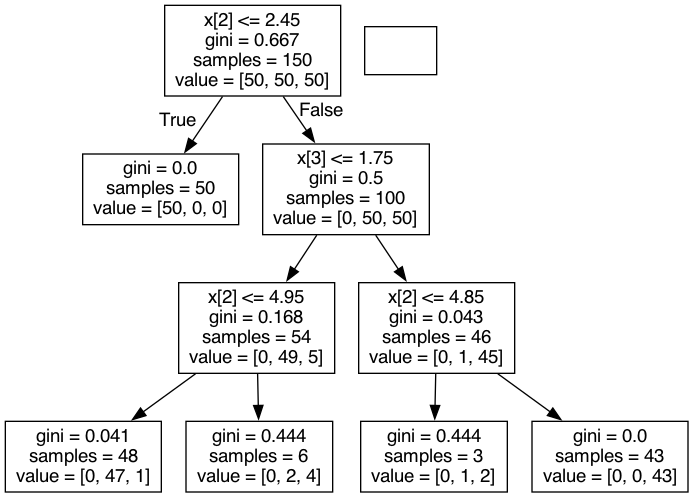

In [51]:
import six
from six import StringIO
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(iris.data, iris.target)
predicted = clf.predict(iris.data)
sum(predicted == iris.target) / len(iris.target)
tree.export_graphviz(clf, out_file="tree.dot",
                         feature_names=iris.feature_names,
                         class_names=iris.target_names,
                         filled=True, rounded=True)
import pydotplus
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
from IPython.display import Image
Image(graph.create_png())

なお、このグラフは、上に掲載したRというソフトウェアで作成した図とは異なっている。 これは、ソフトウェアの違いによるのではない。 実は、決定木では、枝（条件）をどれだけ設定するのか、そのチューンナップが必要である。 決定木においても、枝（条件）は少ないほうがよい（オッカムの剃刀）。 そこで、枝を剪定（せんてい：prune）するという作業が必要になる。

[外部サイト：Wikipedia：Decision tree pruning](https://en.wikipedia.org/wiki/Decision_tree_pruning)

決定木は、直感的で分かりやすいグラフを作成することができる。また、標準化などの前処理が不要である（データのスケールが分析に影響しない）。 そのため、データサイエンス分野において広く用いられているが、後述する過学習に陥りやすいという欠点がある。 そのため、現在では、決定木を多数作成して、その平均あるいは多数決でモデルを調整することが行われている。この方法を **アンサンブル学習(ランダムフォレスト)** という。

<iframe width="560" height="315" src="https://www.youtube.com/embed/J4Wdy0Wc_xQ" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>



## サポートベクターマシン

サポートベクターマシンは、一時期、もっとも精度の高い予測手法として、さまざまな分野で応用されてきていた。**ディープラーニング** が浸透してからは、適用される事例が減っているものの、課題によってはディープラーニングよりも効率的に、同じ程度の精度を出すことが可能な手法である。

サポートベクターマシンで分類を行う仕組みは、以下の動画がわかりやすいだろう。なお、最初の動画には日本語字幕がある。

<span style="color: red; ">Key Points of Today's Lecture</span>


<iframe width="560" height="315" src="https://www.youtube.com/embed/Y6RRHw9uN9o" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/efR1C6CvhmE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

`iris` データを例に、サポートベクターマシンをPythonで実行してよう。

動画にもあったように、２値の分類問題では、線形分離（せんけいぶんり：linearly separable）が可能な場合と、線形分離が不可能な場合とがある。
直感的（ちょっかんてき、かんたん）にいうと、線形分離とは、２つのグループの間を線なり面なりでわけられること意味する。

`iris` データには品種が３つあるが、線形で分けることのできる品種と、できない品種がある。まず、それを図で確認しよう。データの読み込みから行う。

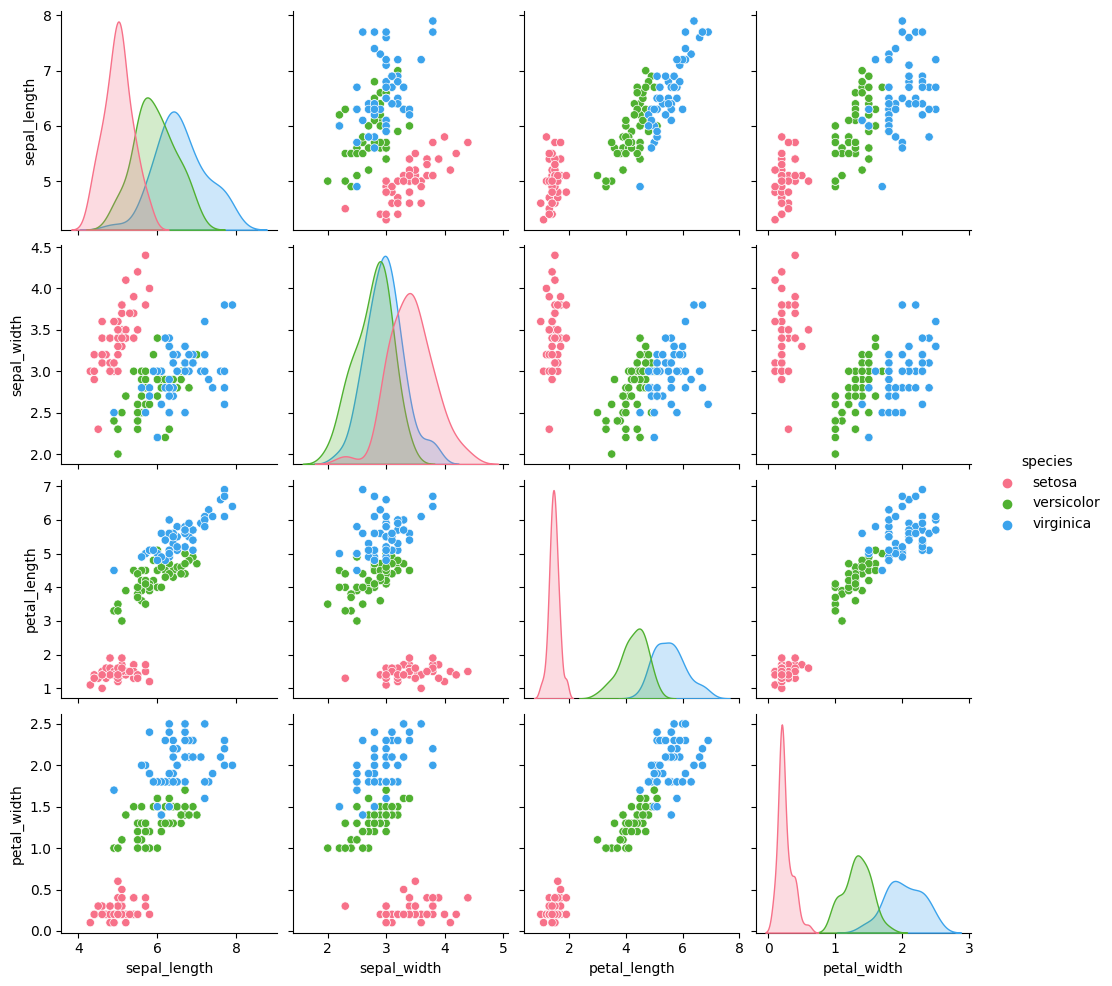

In [32]:
from sklearn.datasets import load_iris
import seaborn as sns
iris_dataset = sns.load_dataset("iris")
sns.pairplot(iris_dataset, hue='species', palette="husl")

この図から、赤いドットで表されてる `setosa` 品種については線を引くことで、他の品種と分けることができそうです。しかし、`versicolor` と `virginica` については、線分で完全に分けることは難しそうである。まず `setosa`と`versicolor`の２種類にわけて、サポートベクターマシンで、この２つを分ける問題を行ってみよう。データの準備から始めよう。グラフにした場合に分かりやすくするため、`iris`から２品種だけ取り出し、また特徴量は`sepal length`と`sepal width`の２つにする。

In [33]:
import pandas as pd
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target_names[iris.target]
df2 = df[(df['target']=='versicolor') | (df['target']=='setosa')] 

In [34]:
# 説明変数を用意（もとデータの１，２列、`sepal length`と`sepal width`のみ使う）
X = df2.iloc[:,:2]
# setosaをラベル 0, versicolorをラベル1とする
y = df2['target'].map({'setosa': 0, 'versicolor': 1})
# データを分割# 80%のデータを学習データに、20%をテストデータにする
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

訓練データの説明変数（`sepal`と`petal`それぞれの幅と長さ）を標準化する。

In [35]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler() 
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

線形のサポートベクターマシンであやめ個体を品種ごとに分離してみよう。

In [36]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear')
svm.fit(X_train_std,y_train) 

SVC(kernel='linear')

訓練データで学習した結果に、訓練データの説明変数を使って予測し、２つの品種が線分でわけられているかを、可視化で確認する。


Text(0, 0.5, 'sepal_width')

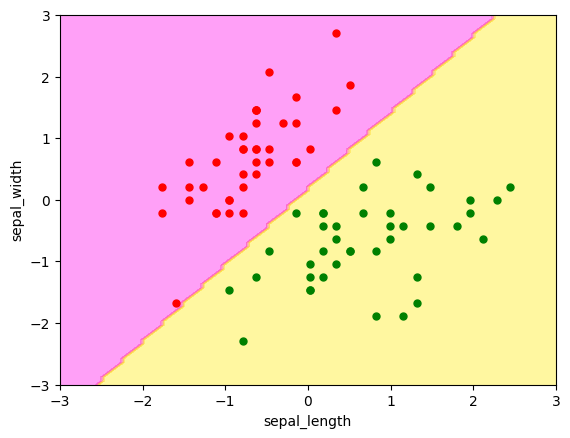

In [37]:
import numpy as np
x0 = np.linspace(-3.0, 3.0, 100)
x1 = np.linspace(-3.0, 3.0, 100)
x0, x1 = np.meshgrid(x0, x1)
X_ = np.c_[x0.ravel(), x1.ravel()]
y_pred = svm.predict(X_).reshape(x0.shape)
y_decision = svm.decision_function(X_)
plt.contourf(x0, x1, y_pred, cmap='spring', alpha=0.4)
# plt.contourf(x0, x1, y_decision, alpha=0.2)
plt.plot(X_train_std[:, 0][y_train==0], X_train_std[:, 1][y_train==0], "ro", ms=5)
plt.plot(X_train_std[:, 0][y_train==1], X_train_std[:, 1][y_train==1], "go", ms=5)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

上の図では、左上と右下で、個体の品種(species)が分けられているようである。ちなみに、学習結果を使ってテストデータを予測し、正解率を確認しよう。

In [38]:
y_pred = svm.predict(X_test_std)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

1.0

上の図からよみとれる結果と同じで、品種を完全に予測できていることが確認できる（ただし、これは小さなサンプルデータだから完全な正解がえられるのであり、もしも実務で行った分析で100％の正解率がでたら、どこかの手順に問題があると疑ったほうが良い）。 次に、非線形分離の例を紹介しよう。説明変数を線形でわけられないデータの場合、動画でもあったように、 サポートベクターマシンでは、もとの説明変数から新たに特徴量を作り出して、この新しい特徴量にもとづいて分類を行う。 ただし、現実には新しい特徴量を作るのは計算などのコストがかかる。これを、サポートベクターマシンではトリックを使って回避している（**カーネルトリック**という）。

[外部サイト：ウィキペディア：カーネル法](https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%BC%E3%83%8D%E3%83%AB%E6%B3%95)

散布図から、完全な分別が難しいようにみえた `virginica`と`versicolor`の２つを分けることを試みてみよう。簡単のため、特徴量は`sepal length`と`sepal width`の２つにする。

In [39]:
import pandas as pd
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target_names[iris.target]
df2 = df[(df['target']=='virginica') | (df['target']=='versicolor')]
# 説明変数を用意（もとデータの１，２列、`sepal length`と`sepal width`のみ使う）
X = df2.iloc[:,:2]#X = df2.drop('target', axis=1)
# versicolorをラベル 0, virginicaをラベル1とする
y = df2['target'].map({'virginica': 1, 'versicolor': 0})
# データを分割# 80%のデータを学習データに、20%をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

サポートベクターマシンを適用するが、ここでカーネルトリックとしてRBFカーネル(Radial basis function kernel)を指定する。



In [40]:
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf')
svm.fit(X_train_std,y_train) 

SVC()

訓練データで学習した結果に、訓練データの説明変数を使って予測し、２つの品種がわけられているかを、可視化で確認する。

Text(0, 0.5, 'sepal_width')

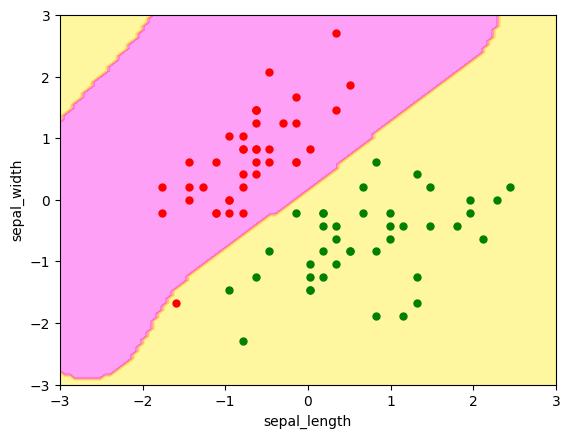

In [41]:
import numpy as np
x0 = np.linspace(-3.0, 3.0, 100)
x1 = np.linspace(-3.0, 3.0, 100)
x0, x1 = np.meshgrid(x0, x1)
X_ = np.c_[x0.ravel(), x1.ravel()]
y_pred = svm.predict(X_).reshape(x0.shape)
y_decision = svm.decision_function(X_)
plt.contourf(x0, x1, y_pred, cmap='spring', alpha=0.4)
# plt.contourf(x0, x1, y_decision, alpha=0.2)
plt.plot(X_train_std[:, 0][y_train==0], X_train_std[:, 1][y_train==0], "ro", ms=5)
plt.plot(X_train_std[:, 0][y_train==1], X_train_std[:, 1][y_train==1], "go", ms=5)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

この図では分離は直線で行われていなこことが確認できるだろう。また、左下にある赤い点を１つだけ分類を誤っている。この学習モデルでテストデータを予測してみよう。

In [42]:
y_pred = svm.predict(X_test_std)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

1.0

### SVMのハイパーパラメータ

最後の分析では、訓練データで予測を1つ誤っていた。実は、サポートベクターマシンには誤分類をどれだけ許容するかを指定するハイパーパラメータ C がある。Cを大きくすると訓練データに対する誤分類は減るが、汎化性能は落ちてくる。つまり過学習となる。

ここで利用したPythonの関数 `SVM()` ではCにデフォルト値として1.0が与えられている。たとえば C に 10を指定して改めて分類しなおしてみよう。

Text(0, 0.5, 'sepal_width')

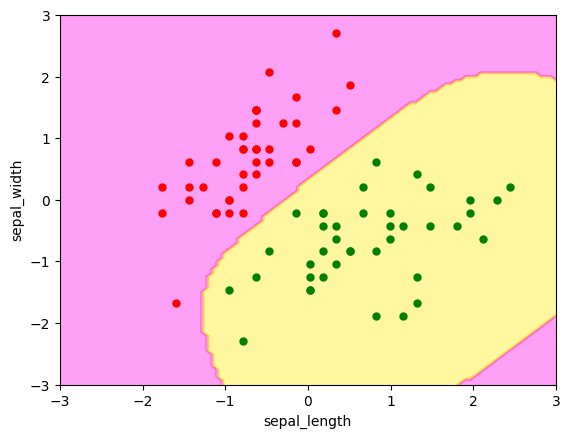

In [44]:
svm = SVC(kernel = 'rbf', C=10)
svm.fit(X_train_std,y_train)
x0 = np.linspace(-3.0, 3.0, 100)
x1 = np.linspace(-3.0, 3.0, 100)
x0, x1 = np.meshgrid(x0, x1)
X_ = np.c_[x0.ravel(), x1.ravel()]
y_pred = svm.predict(X_).reshape(x0.shape)
y_decision = svm.decision_function(X_)
plt.contourf(x0, x1, y_pred, cmap='spring', alpha=0.4)
# plt.contourf(x0, x1, y_decision, alpha=0.2)
plt.plot(X_train_std[:, 0][y_train==0], X_train_std[:, 1][y_train==0], "ro", ms=5)
plt.plot(X_train_std[:, 0][y_train==1], X_train_std[:, 1][y_train==1], "go", ms=5)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

訓練データもうまく分類されていることがわかる。

先に紹介した正則化回帰分析の$\lambda$や$\alpha$、またサポートベクターマシンのCなど、機械学習の手法には、係数パラメータのほかに、機械学習の手法をチューンナップするハイパーパラメータがある。これらのハイパーパラメータは、課題およびデータセットごとに調整しなければならない。これは力わざ(brute force) で、ハイパーパラメータの候補をある数値範囲内に設定し、片っ端から試してみることになる。これをGrid Searchという。PythonやRといった機械学習をサポートするプログラミング言語では、Grid Searchを効率的に実施するライブラリが完備されている。

<!--
 ![](images/kernel.png)
## XGBoost
## アンサンブル学習
## バギング
## ディープラーニング
-->


## ディープラーニング

さて、最後にディープラーニングについてとりあげよう。ディープラーニングについても、まずは以下の動画を見てもらうのが良いだろう。

<span style="color: red; ">Key Points of Today's Lecture</span>

<iframe width="560" height="315" src="https://www.youtube.com/embed/aircAruvnKk" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

（右下の字幕をONにすると、日本語の字幕が表示される）

<Iframe width="560" height="315" src="https://www.youtube.com/embed/6M5VXKLf4D4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

ディープラーニングもまた機械学習の1つである。ちなみに、ディープラーニングに対して、それ以外の機械学習の手法をシャローラーニングということがある。簡単にいうと、一般に機械学習では $y = \, a_1 \, x_1, \, a_2 \, x_2 \dots a_n \, x_n$ として説明変数から応答変数を予測した。一方、ディープラーニングでは、$y$ と $a_1 \, x_1, \, a_2 \, x_2 \dots a_n \, x_n$ の間に「層」が存在する。 $a_1 \, x_1, \, a_2 \, x_2 \dots a_n \, x_n$ を学習したあと、中間の層を設定し、さらに（単純化すると） $a_{2,1} , a_{2,2} \,\dots a_{2,n}$ とパラメータの推定を続けるのである。

一般の機械学習は、この層がないか、あっても１つか２つ程度であるが、ディープラーニング（深層学習）は、層がいくつも（数十、数百と・・・）積み重ねられて、最終的な予測が出力されるのである。

ディープラーニングは、たとえば画像認識や自動翻訳などの分野では、ほぼ標準的な分析手法であり、応用も進んでいる（我々はすでに多くの恩恵（おんけい：benefit）にあずかっている）。

また、PythonやRといったプログラミング言語では、ディープラーニングを手軽に実行することのできるライブラリが多数用意されており、画像認識をためすだけであれば、比較的簡単なコードを書くだけで実現できる。興味のある人は keras や pyTorch といったキーワードで検索してみるといいただろう。また Google Colaboratory ではクラウドでディープラーニングを実行できるJupyter Notebookが公開されている。しかも、小規模な分析を試してみるだけであれば無料である（ユーザ情報とクレジットカードの登録は必要である）。ただし、うっかり長い時間を利用し続けると、後日、Googleから請求書が送信されてきたりするので注意するように。

ディープラーニングのためのツールが多数公開されているといっても、自身が独自に設定した分類問題などを、１からコンピュータに学習させ、精度の高い予測を実現するためには、大量の入力（データ）、また学習モデルでの層の指定など、試行錯誤が必要になる。またディープラーニングは計算量が多いため、GPU（グラフィックスカード）を追加するなど、ハードウェアの追加も必要である。とはいえ、大量のデータがあって、これを分類したい。ただ、分類の根拠、理由について詳しく理解する必要もないという場合、ディープラーニングは非常に強力なツールである。